In [ ]:
import cv2
import os
import numpy as np
import torch
import torch.nn as nn
from transformers import SwinForImageClassification
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import torch.nn.functional as F
from tensorflow.keras.utils import to_categorical
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
from google.colab import files
files.upload()  # Upload kaggle.json

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"gudurusaicharanreddy","key":"0cc096876ead8b2a2048065a91383764"}'}

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json  # Set permission to protect the token

In [ ]:
!pip install kaggle

In [ ]:
!kaggle datasets download -d hungle3401/faceforensics

Dataset URL: https://www.kaggle.com/datasets/hungle3401/faceforensics
License(s): DbCL-1.0
100% 2.72G/2.73G [00:25<00:00, 88.8MB/s]
100% 2.73G/2.73G [00:25<00:00, 117MB/s] 


In [ ]:
import zipfile

# Assuming the downloaded dataset is in a zip file
with zipfile.ZipFile('faceforensics.zip', 'r') as zip_ref:
    zip_ref.extractall()

In [ ]:
# Define paths to the dataset folders
real_video_dir = "/content/FF++/real"
fake_video_dir = "/content/FF++/fake"
frame_count = 10  # Number of frames to extract per video

In [ ]:
# Step 1: Extract Frames from Videos

def extract_frames_from_video(video_path, frame_count):
    cap = cv2.VideoCapture(video_path)
    frames = []
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    interval = max(1, total_frames // frame_count)  # Prevent division by zero

    for i in range(frame_count):
        cap.set(cv2.CAP_PROP_POS_FRAMES, i * interval)
        ret, frame = cap.read()
        if ret:
            frame = cv2.resize(frame, (224, 224))
            frames.append(frame)
    cap.release()
    frames = np.array(frames) / 255.0  # Normalize to [0, 1]
    return frames

In [ ]:
# Step 2: Load Data from FaceForensics++

X, y = [], []

# Load real videos
real_videos_loaded = 0
for video_file in os.listdir(real_video_dir):
    if real_videos_loaded >= 100:
      break
    video_path = os.path.join(real_video_dir, video_file)
    frames = extract_frames_from_video(video_path, frame_count)
    X.append(frames)
    y.append(0)  # Label 0 for real videos
    real_videos_loaded += 1

# Load fake videos
fake_videos_loaded = 0
for video_file in os.listdir(fake_video_dir):
    if fake_videos_loaded >= 100:
      break
    video_path = os.path.join(fake_video_dir, video_file)
    frames = extract_frames_from_video(video_path, frame_count)
    X.append(frames)
    y.append(1)  # Label 1 for fake videos
    fake_videos_loaded += 1

X = np.array(X)  # Shape: (num_videos, frame_count, height, width, channels)
y = to_categorical(np.array(y))  # Convert labels to one-hot encoding

In [ ]:
# Step 3: Convert Data to PyTorch Tensors and Prepare DataLoader

X_tensor = torch.tensor(X, dtype=torch.float32).permute(0, 1, 4, 2, 3)  # Convert to (batch, frames, channels, h, w)
y_tensor = torch.tensor(y, dtype=torch.long)

dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

In [ ]:
class Temporal3DCNN(nn.Module):
    def __init__(self):
        super(Temporal3DCNN, self).__init__()
        self.conv3d_1 = nn.Conv3d(3, 64, kernel_size=(3, 3, 3), stride=1, padding=1)
        self.conv3d_2 = nn.Conv3d(64, 128, kernel_size=(3, 3, 3), stride=1, padding=1)
        self.conv3d_3 = nn.Conv3d(128, 256, kernel_size=(3, 3, 3), stride=1, padding=1)
        self.pool = nn.AdaptiveAvgPool3d((1, 1, 1))
        self.fc = nn.Linear(256, 512)

    def forward(self, x):
        x = F.relu(self.conv3d_1(x))
        x = F.relu(self.conv3d_2(x))
        x = F.relu(self.conv3d_3(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [ ]:
# Step 4: Initialize Swin Transformer Model for FaceForensics++

swin = SwinForImageClassification.from_pretrained("microsoft/swin-tiny-patch4-window7-224", num_labels=2, ignore_mismatched_sizes=True)

# Freeze initial layers to speed up training
for param in swin.parameters():
    param.requires_grad = False
for param in swin.classifier.parameters():
    param.requires_grad = True  # Only train the classifier layer

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/71.8k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/113M [00:00<?, ?B/s]

Some weights of SwinForImageClassification were not initialized from the model checkpoint at microsoft/swin-tiny-patch4-window7-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
class FusionModel(nn.Module):
    def __init__(self, swin, temporal_cnn):
        super(FusionModel, self).__init__()
        self.swin = swin
        self.temporal_cnn = temporal_cnn
        self.fc_fusion = nn.Linear(514, 2)

    def forward(self, x):
        batch_size, frames, channels, height, width = x.size()

        x_swin = x.view(batch_size * frames, channels, height, width)
        swin_features = self.swin(x_swin).logits
        swin_features = swin_features.view(batch_size, frames, -1)
        swin_features = swin_features.mean(dim=1)

        x_3d = x.permute(0, 2, 1, 3, 4)
        temporal_features = self.temporal_cnn(x_3d)

        fused_features = torch.cat((swin_features, temporal_features), dim=1)
        output = self.fc_fusion(fused_features)

        return output

In [ ]:
temporal_cnn = Temporal3DCNN()
fusion_model = FusionModel(swin, temporal_cnn)

optimizer = Adam(fusion_model.parameters(), lr=1e-3)
num_epochs = 30

In [ ]:
for epoch in range(num_epochs):
    fusion_model.train()
    total_loss, correct_predictions, total_predictions = 0, 0, 0

    for batch_X, batch_y in dataloader:
        optimizer.zero_grad()
        outputs = fusion_model(batch_X)
        loss = F.cross_entropy(outputs, batch_y.float())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        preds = torch.argmax(outputs, dim=1)
        correct_predictions += (preds == batch_y.argmax(dim=1)).sum().item()
        total_predictions += batch_y.size(0)

    print(f"Epoch {epoch+1}/{num_epochs}, Accuracy: {correct_predictions / total_predictions}, Loss: {total_loss / len(dataloader)}")

Epoch 1/30, Accuracy: 0.42, Loss: 0.7091512966156006
Epoch 2/30, Accuracy: 0.5, Loss: 0.694423885345459
Epoch 3/30, Accuracy: 0.64, Loss: 0.6855265569686889
Epoch 4/30, Accuracy: 0.635, Loss: 0.6701306438446045
Epoch 5/30, Accuracy: 0.73, Loss: 0.642466893196106
Epoch 6/30, Accuracy: 0.74, Loss: 0.6200598692893982
Epoch 7/30, Accuracy: 0.74, Loss: 0.5872719693183899
Epoch 8/30, Accuracy: 0.745, Loss: 0.5655012559890747
Epoch 9/30, Accuracy: 0.76, Loss: 0.5428056311607361
Epoch 10/30, Accuracy: 0.765, Loss: 0.5320087587833404
Epoch 11/30, Accuracy: 0.775, Loss: 0.511291229724884
Epoch 12/30, Accuracy: 0.765, Loss: 0.48970181941986085
Epoch 13/30, Accuracy: 0.785, Loss: 0.4853487503528595
Epoch 14/30, Accuracy: 0.805, Loss: 0.46886873841285703
Epoch 15/30, Accuracy: 0.79, Loss: 0.46031531870365144
Epoch 16/30, Accuracy: 0.805, Loss: 0.44991068601608275
Epoch 17/30, Accuracy: 0.78, Loss: 0.4438080948591232
Epoch 18/30, Accuracy: 0.815, Loss: 0.436426973938942
Epoch 19/30, Accuracy: 0.825,

In [ ]:
fusion_model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for batch_X, batch_y in dataloader:
        outputs = fusion_model(batch_X)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        batch_y_single_label = torch.argmax(batch_y, dim=1)  # Convert one-hot to single label
        all_labels.extend(batch_y_single_label.cpu().numpy())

print("Accuracy:", accuracy_score(all_labels, all_preds))
print("Classification Report:\n", classification_report(all_labels, all_preds))

Accuracy: 0.84
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.78      0.83       100
           1       0.80      0.90      0.85       100

    accuracy                           0.84       200
   macro avg       0.84      0.84      0.84       200
weighted avg       0.84      0.84      0.84       200



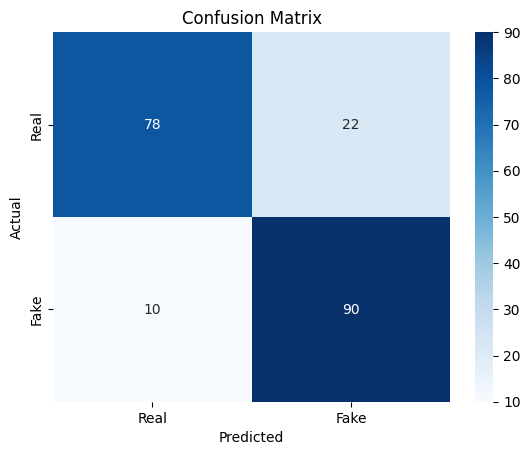

In [ ]:
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Real", "Fake"], yticklabels=["Real", "Fake"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

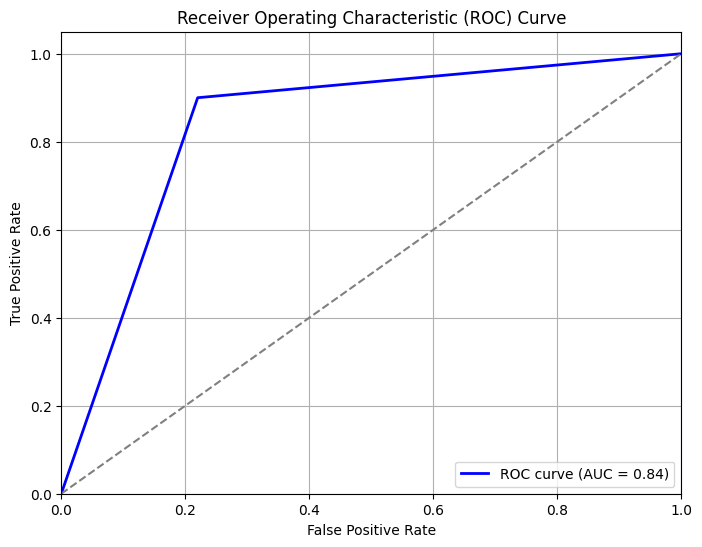

In [ ]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(all_labels, all_preds)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')  # Diagonal line for reference
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [ ]:
# Save the trained model
model_path = "fusion_model.pth"
torch.save(fusion_model.state_dict(), model_path)

In [ ]:
# Download the model to your local system
from google.colab import files
files.download(model_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>